In [10]:
!pip install langchain_community
!pip install langchain_openai
!pip install pytube
!pip install gdown
!pip install yt_dlp
!pip install python-dotenv
!pip install faiss-cpu
!pip install fastembed

In [11]:
from ai_agents import bemyapp_agent
from general_functions import faiss_index
from langchain_core.messages import HumanMessage
from langchain_community.utilities import SQLDatabase
import os

current_agent = "text_to_sql_agent"
text2sql_chat_history = []

questions = {
    "text_to_sql_agent": [
        "What was the total profit for each product in the year 2014?",
        "how about 2013?",
        "by country",
    ],
    "switch_to_multimodal_rag_agent": [
        "I have a question about my video",
    ],
    "multimodal_rag_agent": [
        #  can be answered without images
        "What is the origin of Interactive Technical Manuals (ITMs), and how have they evolved since their creation?",
        "How can ITMs benefit technicians and engineers in troubleshooting and maintaining complex equipment?"
        # need images to answer
        "How does the ITM's schematic interface enhance the understanding of complex hydraulic systems?",
        "What kind of information is typically included in a component sheet within the ITM system?",
    ],
    "switch_to_recursive_rag_agent": [
        "I have a question about my contracts",
    ],
    "recursive_rag_agent": [
        "Which companies provide design services for us?",
        "What is the cost of services of CreativeMind?",
        "Give me contacts of CreativeMind",
    ]
}

db = SQLDatabase.from_uri("sqlite:///text_to_sql_example.db")
multimodal_rag_index = faiss_index(index_name="faiss_index_multimodal_rag")
recursive_rag_index = faiss_index(index_name="faiss_index_recursive_rag")


text_to_sql_agent: (text_to_sql_agent) Great! What is your question?


text_to_sql_agent: In 2014, the total profit for each product was as follows:

- Amarilla: $2,032,154.54
- Carretera: $1,788,036.03
- Montana: $1,656,996.84
- Paseo: $3,697,584.87
- VTT: $2,156,422.79
- Velo: $1,684,042.71


text_to_sql_agent: In the year 2013, the total profits for each product were as follows:

- Amarilla: $781,949.53
- Carretera: $38,768.86
- Montana: $457,758.04
- Paseo: $1,099,853.09
- VTT: $878,185.23
- Velo: $621,949.76


text_to_sql_agent: In the year 2013, the total profit for each product broken down by country is as follows:

- **Amarilla**
  - Canada: $250,085.86
  - France: $149,441.11
  - Germany: $261,072.15
  - Mexico: $27,669.29
  - United States of America: $93,681.12

- **Carretera**
  - Canada: $12,850.56
  - France: -$10,712.16 (loss)
  - Germany: $18,947.78
  - Mexico: $9,962.92
  - United States of America: $7,719.76

- **Montana**
  - Canada: $42,193.79
  - France: $30,082.09

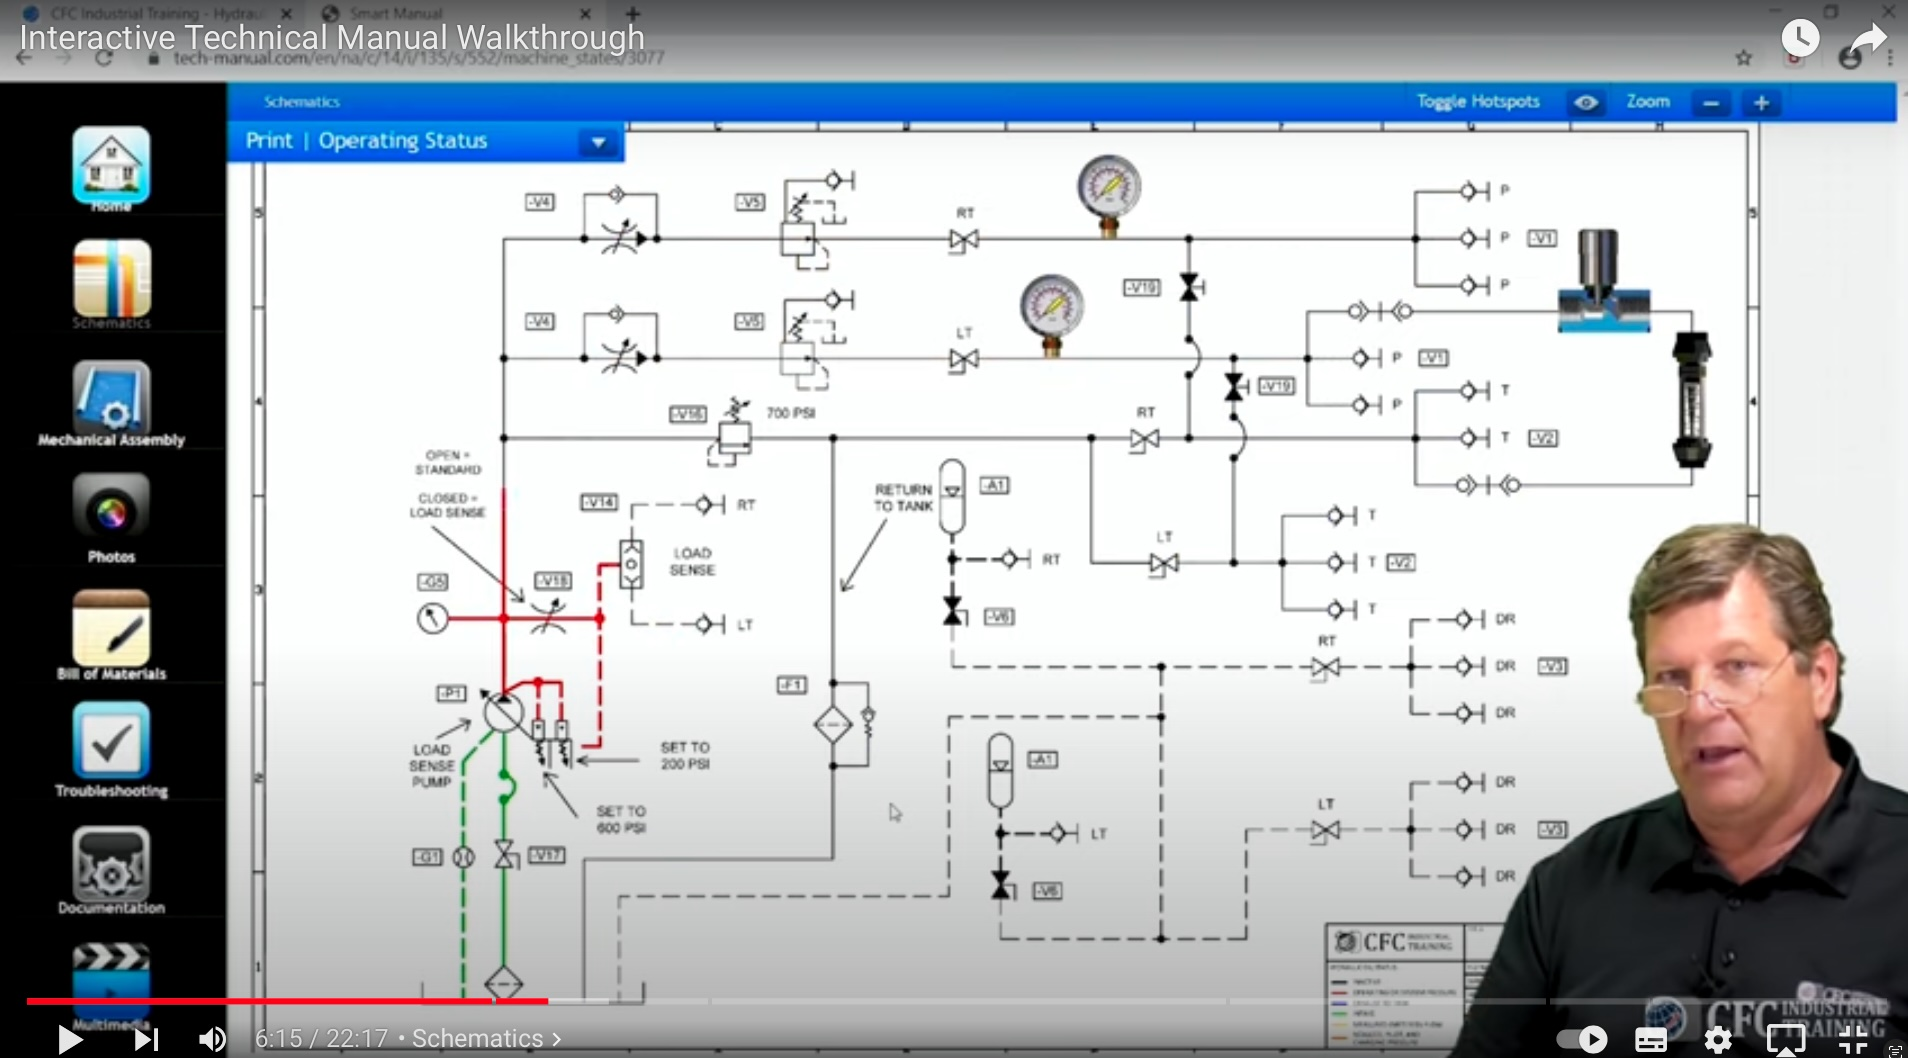



recursive_rag_agent: (recursive_rag_agent) Great! What is your question?


recursive_rag_agent: Innovate Spaces Corporation engages **CreativeMind Design Studio, LLC** to provide design services.

If you have any more specific questions or need further details, feel free to ask!


recursive_rag_agent: Based on the provided context, here is the relevant information regarding the cost of services for Innovate Spaces Corporation:

1. **Design Services Agreement with CreativeMind Design Studio, LLC**:
   - **Total Fee**: $750,000
   - **Payment Schedule**:
     - 20% ($150,000) upon execution of the Agreement
     - 20% ($150,000) upon completion of Schematic Design phase
     - 25% ($187,500) upon completion of Design Development phase
     - 25% ($187,500) upon completion of Construction Documents
     - 10% ($75,000) upon substantial completion of Construction Administration
   - **Additional Services**:
     - Principal Designer: $250/hour
     - Senior Designer: $200/hour
     - Jun

In [14]:
while 1:
    question = input(f"Your message to {current_agent}: ")
    if question == "exit":
        break
    text2sql_chat_history.append(HumanMessage(content=question))
    response = bemyapp_agent(question, current_agent, text2sql_chat_history, multimodal_rag_index, recursive_rag_index, db)
    current_agent = response["next_agent"]
    # Check if the answer contains media references
    if "MEDIA: " in response['answer']:
        # Split the answer and media part
        answer, media = response['answer'].split("MEDIA: ")
        # Strip any whitespace
        media = media.strip()
        # Split multiple media files if present
        media_files = media.split(", ")
        
        print(f"{current_agent}: {answer}")
        
        # Display each media file
        for media_file in media_files:
            media_file = media_file.replace(".png", ".jpeg").strip('"')
            if not media_file:
                continue
            print(f"DEBUG: trying to embed {media_file}")
            from IPython.display import Image, display
            image_path = f"data/for_multimodal_rag/{media_file}"
            try:
                # Load and display the image
                display(Image(filename=image_path))
            except Exception as e:
                print(f"Error displaying {media_file}: {str(e)}")
                # If there's an error, try to display using PIL
                try:
                    from PIL import Image as PILImage
                    img = PILImage.open(image_path)
                    display(img)
                except Exception as inner_e:
                    print(f"Error displaying {media_file} with PIL: {str(inner_e)}")
                    # If both methods fail, provide a more informative error message
                    print(f"The image file '{media_file}' could not be found or displayed. Please check if the file exists in the 'data/for_multimodal_rag/' directory and ensure the filename is correct.")
    else:
        # If no media, just print the answer as before
        print(f"{current_agent}: {response['answer']}")
    print("")
    print("")